In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
#from torch.autograd import Variable
#import cv2
import numpy as np
#import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = './lfw/lfw'

In [3]:
transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
"""
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


torch.Size([250, 250, 3])


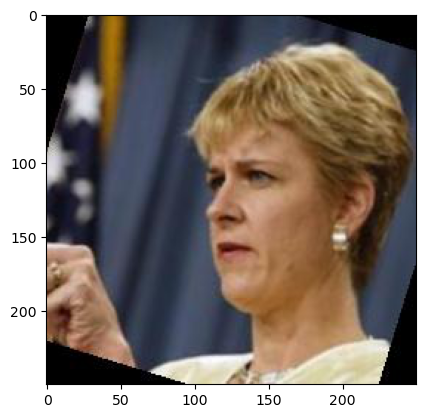

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Difference in Applications:
- Autoencoders are used in domains such as image denoising, feature extraction, data compression, and anomaly detection. They are effective for reconstructing input data from compressed representations. While VAEs excel in generative tasks such as image generation, style transfer, and learning continuous latent representations.

Difference in architecture:
- Structure: The encoder network compresses the input into a latent space representation and the decoder network reconstructs the input from this representation. VAE uses a probabilistic approach to encoding by generating a distribution (usually Gaussian/Normal) for each latent variable.
- Mapping: The encoder directly maps input data to a fixed representation while VAEs sample latent variables from the learned distribution instead of a deterministic mapping.

Difference in Loss function:
- Both autoencoders and variational autoencoders typically use a loss function such as Mean Squared Error (MSE) that measures the difference between the input and the output (reconstruction) of the autoencoder. The VAEs also have an extra term - KL Divergence. It acts as a regularization term that ensures the latent space distribution closely matches a prior distribution, encouraging the learned representations to be continuous and well-structured.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
class VAE(nn.Module):
    def __init__(self, embedding_dim=50):
        super(VAE, self).__init__()
        self.encoding_layers = nn.Sequential(
            nn.Conv2d(3, 256, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 128, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv2d(128, 64, 2, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(64 * 32 * 32, embedding_dim)
        self.fc_log_var = nn.Linear(64 * 32 * 32, embedding_dim)
        self.fc_decoder = nn.Linear(embedding_dim, 64 * 32 * 32)
        self.reshape = lambda x: x.view(-1, *(64,32,32))
        self.decoding_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 2, stride=2, padding=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoding_layers(x)
        x = self.flatten(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var
    
    def decode(self, z):
        x = self.fc_decoder(z)
        x = self.reshape(x)
        x = self.decoding_layers(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = torch.randn_like(mu) * torch.exp(0.5 * log_var) + mu
        reconstruction = self.decode(z)
        return mu, log_var, reconstruction

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [8]:
model = VAE().to(device)

In [9]:
sample = next(iter(dataloader))
image = sample[0][0].to(device)
encoder_output = model.encode(image.unsqueeze(0))
print("Size of mean (encoder output 1):", encoder_output[0].size())
print("Size of log_var (encoder output 2):", encoder_output[1].size())
z = torch.randn_like(encoder_output[0]) * torch.exp(0.5 * encoder_output[1]) + encoder_output[0]
reconstruction = model.decode(z)
print("Size of reconstructed image (decoder output):",reconstruction.size())

Size of mean (encoder output 1): torch.Size([1, 50])
Size of log_var (encoder output 2): torch.Size([1, 50])
Size of reconstructed image (decoder output): torch.Size([1, 3, 250, 250])


The output of the encoder is a tuple of size 2 i.e. the mean and the log variance.
Both of them are tensors of size - 1x50

Generating new samples in the latent space:
1. The encoder generates the mean and log-variance for each latent variable based on the input data. (Which basically gives us the distribution) 
2. New samples are created by sampling from the learned distribution of latent variables.
3. Gaussian noise is sampled from a standard normal distribution and is multiplied by the standard deviation and added to the mean obtained during the encoding process: `z = mu + std * epsilon`, where epsilon ~ N(0, 1). By changing the sampled latent variables z (while keeping the network weights fixed), new samples can be generated.
4. The sampled latent variables z are then passed through the decoder network.

The output of the decoder is also 3x250x250, which is the same size as the input image. This shows that the forward pass is working properly.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [10]:
# The code iterates through all the parameters of the model, counting the number of elements in each parameter tensor,
# and then sums up these counts to determine the total number of parameters in the model.
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

print("Total number of parameters:", sum(p.numel() for p in model.parameters()))

Total number of parameters: 10372071


* create an optimizer for training

In [11]:
import torch.optim as optim
optim = optim.Adam(model.parameters(), lr=0.001)

#### LOSS FUNCTION

The loss function comprises of two components: the Kullback-Leibler (KL) divergence term and the reconstruction (fit) loss term.

**KL Divergence Term:**
- The KL divergence term measures the divergence between the learned distribution of latent variables and a predefined prior distribution.
- $$\text{kl} = -0.5 \times \left(1 + \text{log\_var} - \text{mu}^2 - \exp(\text{log\_var})\right)$$
- log_var and mu are the log-variance and mean vectors obtained from the encoder during the VAE's training.
- This term penalizes the learned distribution for deviating from the prior distribution, encouraging the learned latent space to resemble the specified distribution.


**Reconstruction (Fit) Loss Term:**
- The reconstruction loss measures the difference between the input data and the output (reconstructed) data.
- $$\text{fit} = 0.5 \times (\text{output} - \text{input})^2$$
- input represents the input data, and output represents the reconstructed output or images from the VAE.
- It computes the mean squared error (MSE) between the input and reconstructed output.

**Final Loss:**
The final loss function is the sum of the KL divergence loss and the reconstruction (fit) `loss = kl_loss + fit_loss`
This combined loss is used to train the VAE during optimization, balancing the reconstruction accuracy with the regularization of the latent space.



In [12]:
def loss_func(input, output, mu, log_var):
    kl = - 0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
    kl_loss = kl.sum() / input.size(0)
    fit = 0.5 * (output - input).pow(2)
    fit_loss = fit.sum() / input.size(0)
    return kl_loss + fit_loss

# Assigning the function to the variable
loss_function = loss_func

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [13]:
# Total number of epochs the model will be trained for
num_epochs = 15

for epoch in range(num_epochs):
    total_loss = 0.0
    
    # For each of the batch in the dataloader
    for data in dataloader:
        # Split the data into images and targets
        images, _ = data
        # Move all the images to the GPU
        images = images.to(device)
        
        # Forward Pass - Perform Encoding + Decoding and calculating loss
        mean, var, output = model(images)
        loss = loss_function(images, output, mean, var)
        
        # Backward Pass - Reset the gradients, compute new gradients and update it
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # Accumulate the loss for all the batches in the epoch 
        total_loss += loss.item()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss))

Epoch [1/15], Loss: 1342033.7734
Epoch [2/15], Loss: 815209.7584
Epoch [3/15], Loss: 739503.5195
Epoch [4/15], Loss: 714064.9287
Epoch [5/15], Loss: 698411.7408
Epoch [6/15], Loss: 683481.7689
Epoch [7/15], Loss: 671563.8375
Epoch [8/15], Loss: 661552.5874
Epoch [9/15], Loss: 651369.6932
Epoch [10/15], Loss: 642672.0896
Epoch [11/15], Loss: 635173.5403
Epoch [12/15], Loss: 628254.7407
Epoch [13/15], Loss: 620593.1016
Epoch [14/15], Loss: 614883.7706
Epoch [15/15], Loss: 609636.8090


##### There was one instance where the loss would keep increasing:
Epoch [1/30], Loss:7225421989616315392.0000
Epoch [2/30], Loss:27802545083390115840.0000
Epoch [3/30], Loss:1177170727737346518838935552.0000
...
###### Changes to the embedding_dim fixed this.

##### There are times when the loss always shows 'nan':
Epoch [1/10], Loss:nan
Epoch [2/10], Loss:nan
Epoch [3/10], Loss:nan
...
###### Noticed that it is usually caused when embedding_dim is set to a higher value (>128)

For epochs more than 20, the decoder doesn't always generate good images.
For example, the below image is when a model with embedding dimension=96 was run for 30 epochs:
![IMG1](96dim30ep.png)

Embedding dimension = 72, Epochs = 10
![IMG2](72dim10ep.png)

Embedding dimension = 64, Epochs = 10
![IMG2](64dim10ep.png)


The background information got better in range of Embedding_dimension = 40 to 60
Which is why the current model with  Embedding_dimension = 50 was chosen finally.


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

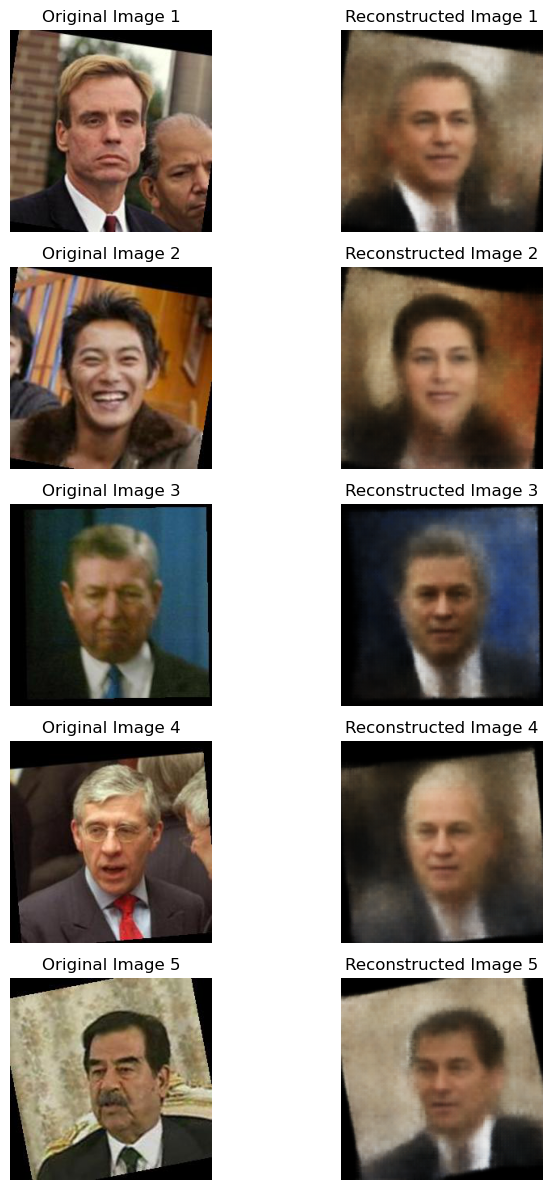

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))

for i in range(1, 6):
    original = sample[0][i]
    original = original.unsqueeze(0).to(device)
    m, v, reconstruction = model(original)
    original = original.squeeze(0).cpu().detach().numpy()
    reconstruction = reconstruction.squeeze(0).cpu().detach().numpy()
    axes[i - 1, 0].imshow(np.transpose(original, (1, 2, 0)))
    axes[i - 1, 0].set_title(f'Original Image {i}')
    axes[i - 1, 0].axis('off')
    axes[i - 1, 1].imshow(np.transpose(reconstruction, (1, 2, 0)))
    axes[i - 1, 1].set_title(f'Reconstructed Image {i}')
    axes[i - 1, 1].axis('off')
plt.tight_layout()
plt.show()